<a href="https://colab.research.google.com/github/fadibechara/MultiGrid/blob/main/MultiGrid_Isotropic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What we will be fundamentally targeting in the study of multigrid methods is the final ***residual*** we would get via multigrid and how it compares to the final residual we get using iterative methods exclusively on the fine grid for the same number of equivalent iterations it took to complete the multi-grid cycle.

This will really drive home the **benefits** of the multigrid-method and how it can **accelerate our path to convergence** working on a continuous system as opposed to just trying to solve the system **naively** with iterative solvers uniquely.



In [136]:
from math import pi, sin, cos, sqrt
import pylab as plt
import numpy as np
import scipy as sp
import scipy.sparse as spa
import scipy.linalg as la
import math
import time
#from matplotlib import rc, rcParams
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text', usetex=True)
#rcParams.update({'font.size': 16})

# Some paramters
_eps =1e-12
_maxiter=500

def _basic_check(A, b, x0):
    """ Common check for clarity """
    n, m = A.shape
    if(n != m):
        raise ValueError("Only square matrix allowed")
    if(b.size != n):
        raise ValueError("Bad rhs size")
    if (x0 is None):
        x0 = np.zeros(n)
    if(x0.size != n):
        raise ValueError("Bad initial value size")
    return x0

In [137]:
def plot_heatmap(u):
  N=u.size
  n=int(math.sqrt(N))
  u = np.reshape(u, (n,n))
  plt.imshow(u, cmap='hot', interpolation='nearest')
  plt.show()

In [138]:
def function(N,h):
  f = np.empty(N, dtype=float)
  n=int(math.sqrt(N))
  for i in range(0,n):
    for j in range(0,n):
      f[i*n+j]=(h**2)*(i*n+j)*(i*n+j)*(h**2)
  return f


The boundary conditions of our system were taken into account while constructing the 3 restriction functions. That is why i and j bothstarted from 0 and ended at n-1 as opposed to starting from 0 to n.
Hence the left, right, botoom and top boundary copnditions were **all pre-determined** using this restriction strategy.
This would help in accelerating our convergence as there would be no need to correct for the boundary conditions later.


In [139]:
def restrict_full(u):
  s=np.size(u,0)
  s=int(math.sqrt(s))
  n=int(s/2)
  uc = np.zeros(n*n, dtype=float)
  #startiing at 1 and ending at n-1 for both i and j to inherrently take into consideration the 4 null boundary conditions
  for i in range(1,n-1):
    for j in range(1,n-1):
      uc[n*i+j]=(4*u[2*i*s+2*j] + 2*u[2*i*s+2*j-1] + 2*u[2*i*s+2*j+1] + 2*u[(2*i-1)*s+2*j] + 2*u[(2*i+1)*s+2*j] + u[(2*i+1)*s+2*j+1] + u[(2*i+1)*s+2*j-1] + u[(2*i-1)*s+2*j+1] + u[(2*i-1)*s+2*j-1])/16

  return uc


In [140]:
def restrict_half(u):
  s=np.size(u,0)
  s=int(math.sqrt(s))
  n=int(s/2)
  uc = np.zeros(n*n, dtype=float)
  #starting at 1 and ending at n-1 for both i and j to inherrently take into consideration the 4 null boundary conditions
  for i in range(1,n-1):
    for j in range(1,n-1):
      uc[n*i+j]=(4*u[2*i*s+2*j] + u[2*i*s+2*j-1] + u[2*i*s+2*j+1] + u[(2*i-1)*s+2*j] + u[(2*i+1)*s+2*j])/8

  return uc

In [141]:
def restrict_injection(u):
  s=np.size(u,0)
  s=int(math.sqrt(s))
  n=int(s/2)
  uc = np.zeros(n*n, dtype=float)
  for i in range(1,n-1):
    for j in range(1,n-1):
      uc[n*i+j]= u[2*i*s+2*j]

  return uc

In [142]:
def prolongate(u):
  s=np.size(u)
  s=int(math.sqrt(s))
  n=int(2*s)
  uf = np.zeros((n)*(n), dtype=float)
  for i in range(2,n-1,2):
    for j in range(2,n-1,2):
      uf[i*n+j]=u[int((i/2)*s+j/2)]
    for j in range(1,n-1,2):
      uf[i*n+j]=(uf[i*n+j-1]+uf[i*n+j+1])/2

  for i in range(1,n-1,2):
    for j in range(0,n-1):
      uf[i*n+j]=(uf[(i-1)*n+j]+uf[(i+1)*n+j])/2

  return uf


Prolongate_injection is a less computationally intesive prolongation method as itakes our matrix and builds a matrix that is 4 times larger using exclusively our matrix' components with no avergaing between.
If we visualise this prolongation method we cn notice a choppier version of our fine grid as opposed to the regular prolongation method.

In [143]:
def prolongate_injection(u):
  s=np.size(u)
  n=int(math.sqrt(s))
  N=int(2*n)
  uf = np.zeros((N)*(N), dtype=float)
  for i in range(0,s):
    j = int(i/n)
    p = i - j*n
    uf[j*2*N+p*2]=uf[j*2*N+p*2+1]=uf[j*2*N+p*2+N]=uf[j*2*N+p*2+N+1]=u[i]
  return uf


The FIVE_diag matrix allows us to multiply A by u hence transforming our governing equation to a matrix vector multiply

In [144]:
def fivediag(N, n, h, sigma=0):
  a=[4+h*h*sigma]*N
  b=[-1]*(N-1)
  c=[-1]*(N-1)
  d=[-1]*(N-n)
  e=[-1]*(N-n)
  A = np.diag(a, 0) + np.diag(b, -1) + np.diag(c, 1) + np.diag(d, -n) + np.diag(e, n)
  A = np.reshape(A, (N, N))
  return A

In [189]:
def sparse_fivediag(N, h, sigma=0):
  A = [4+h*h*sigma,-1]
  return A

In [190]:
#Sparse sor function for a more efficient matrix vector multiplication with less unbenificial computations, this function can only be used in this particular case though, here 'sor' determines whether we will actuallt be unning SOR or JOR
def sparse_SOR(A, b, x, omega=1.5, eps=_eps, maxiter=_maxiter, sor=1):
    start_time = time.time()
    if (omega > 2.) or (omega < 0.):
        raise ArithmeticError("SOR will diverge")

    #x = _basic_check(A, b, x0)   
    residual_history = list()
    disp_history = list()
    N = b.size
    n = int(math.sqrt(N))
    count = 0
    disp = eps+1
    #xn = np.zeros(N)
    while (count<maxiter and disp>eps):
          xn = np.zeros(N)
          for i in range(n,N-n):
            if i%n == 0 or (i+1)%n == 0:
             continue
            s = b[i]
            if (sor==1): s = s - A[i][i-n]*xn[i-n] - A[i][i-1]*xn[i-1] - A[i][i+1]*x[i+1] - A[i][i+n]*x[i+n]
            else :  s = s - A[i][i-n]*x[i-n] - A[i][i-1]*x[i-1] - A[i][i+1]*x[i+1] - A[i][i+n]*x[i+n]
            xn[i]=(1-omega)*x[i]+(omega/(A[i][i]))*s
          r = (xn[0]-x[0])*(xn[0]-x[0])    
          disp = (xn[0]-x[0])*(xn[0]-x[0])
          for i in range(n+1,N-n-1):
            if i%n == 0 or (i+1)%n == 0:
             continue
            r = r + (xn[i]-x[i])*(xn[i]-x[i])  
            dispc=(xn[i]-x[i])*(xn[i]-x[i])
            if(dispc>disp):
               disp=dispc
          x = xn[:]
          r = math.sqrt(r)
          disp = math.sqrt(disp)
          residual_history.append(r)
          disp_history.append(disp)
          count = count+1
    elapsed_time = time.time() - start_time
    print(elapsed_time)
    return x, residual_history, disp_history, count

To be able to solve 1024x1024 without overflowing we could not afford to store the whole A matrix used(resumting in 1024² * 1024² matrix), hence we used a vector of 2 numbers instead since that is all that is present in our matrix in our particular equation.


In [197]:
#this function aims at reducing memory storage and making it possible to compute large values for U, A here is a vector of 2 values since that is all we will need in our particulat circumstance
def sparse_solver(A, b, x, omega=1.5, eps=_eps, maxiter=_maxiter, sor=1):
    start_time = time.time()
    #x = _basic_check(A, b, x0)   
    residual_history = list()
    disp_history = list()
    N = b.size
    n = int(math.sqrt(N))
    count = 0
    disp = eps+1
    while (count<maxiter and disp>eps):
          xn = np.zeros(N)
          for i in range(n+1,N-n-1):
            if i%n == 0 or (i+1)%n == 0:
             continue
            s = b[i]
            if (sor==1): s = s - A[1]*xn[i-n] - A[1]*xn[i-1] - A[1]*x[i+1] - A[1]*x[i+n]
            else: s = s - A[1]*x[i-n] - A[1]*x[i-1] - A[1]*x[i+1] - A[1]*x[i+n]
            xn[i]=(1-omega)*x[i]+(omega/(A[0]))*s
          r = (xn[0]-x[0])*(xn[0]-x[0])
          disp = (xn[0]-x[0])*(xn[0]-x[0])
          for i in range(n+1,N-n-1):
  # states i%n==0 and (i+1)%n==0 represent the top and the bottom of our boundary conditions so no need to calculate their products or their displacements since it will be zero          
            if i%n == 0 or (i+1)%n == 0:
             continue
            r = r + (xn[i]-x[i])*(xn[i]-x[i])  
            dispc=(xn[i]-x[i])*(xn[i]-x[i])
            if(dispc>disp): disp=dispc
          x = xn[:]
          r = math.sqrt(r)
          disp = math.sqrt(disp)
          residual_history.append(r)
          disp_history.append(disp)
          count = count+1
    elapsed_time = time.time() - start_time
    return x, residual_history, disp_history, count

In [192]:
def v_multigrid(x, min=2, omega=1.633, sig=1, sor=1, mode_restrict=0):
  if (mode_restrict==0) : rest = restrict_injection
  elif (mode_restrict==1) : rest = restrict_half
  elif (mode_restrict==2) : rest = restrict_full
  if (sor==0) : solver = sparse_JOR
  elif (sor==1) : solver = sparse_SOR
  start_time = time.time()
  print('Our Initial Guess')
  plot_heatmap(x)
  a=x.size
  rank=0
  while(a!=1):
    a=int(a/2)
    rank=rank+1
  count=rank
  i=1
  total=0
  while(count>(min)):
    N=x.size
    n=int(math.sqrt(N))
    h=1/(n-1)
    A = sparse_fivediag(N,h,sig)
    f = function(N,h)
    e=(1/i)
    x,r,d,c =sparse_solver(A,f,x,omega,e,1,sor)
    total = total + c/(2**(rank-count))
    x=rest(x)
    i=i*1000000000
    count=count-2
  
  while(count<(rank+1)):
    e=(1/i)
    i=i/1000
    N=x.size
    n=int(math.sqrt(N))
    h=1/(n-1)
    A = sparse_fivediag(N,h, sig)
    f = function(N,h)
    if (count!=rank):
      x,r,d,c =sparse_solver(A,f,x,omega,e,100,sor)
    else:
      x,r,d,c =sparse_solver(A,f,x,omega,1e-3,1,sor)
      print('Final Residual')
      print(r[-1])
      
    total = total + c/(2**(rank-count))
    if (count!=rank): x=prolongate(x)
    count=count+2


  plot_heatmap(x)
  elapsed_time = time.time() - start_time
  print('V_MultiGrid Took in SECONDS')
  print(elapsed_time)
  print('Number of equivalent iterations on the FINE GRID')
  print(total)
  return x,r[-1]

In [193]:
def w_multigrid(x, min=4, intermediate=6,  omega=1.633, sig=1, sor=1, mode_restrict=0):
  if (mode_restrict==0) : rest = restrict_injection
  elif (mode_restrict==1) : rest = restrict_half
  elif (mode_restrict==2) : rest = restrict_full
  start_time = time.time()
  total = 0
  a=x.size
  rank=0
  while(a!=1):
    a=int(a/2)
    rank=rank+1
  count=rank
  print('Our Initial Guess')
  plot_heatmap(x)
  i=1
  while(count>(min)):
    N=x.size
    n=int(math.sqrt(N))
    h=1/(n-1)
    A = sparse_fivediag(N,h, sig)
    f = function(N,h)
    e=(1/i)
    x,r,d,c =sparse_solver(A,f,x,omega,e,1,sor)
    total = total + c/(2**(rank-count))
    x=rest(x)
    i=i*1000
    count=count-2

  while(count<intermediate):
    e=(1/i)
    i=i/1000
    N=x.size
    n=int(math.sqrt(N))
    h=1/(n-1)
    A = sparse_fivediag(N,h, sig)
    f = function(N,h)
    e=(1/i)
    x,r,d,c =sparse_solver(A,f,x,omega,e,10,sor)
    total = total + c/(2**(rank-count))
    count=count+2
    if(count!=intermediate): x=prolongate(x)

  while(count>(min)):
    i=i*1000
    N=x.size
    n=int(math.sqrt(N))
    h=1/(n-1)
    A = sparse_fivediag(N,h, sig)
    f = function(N,h)
    e=(1/i)
    x,r,d,c =sparse_solver(A,f,x,omega,e,10,sor)
    total = total + c/(2**(rank-count))
    count=count-2
    if (count>min): x=rest(x)
  
  while(count<(rank+1)):
    c=0
    e=(1/i)
    i=i/1000
    N=x.size
    n=int(math.sqrt(N))
    h=1/(n-1)
    A = sparse_fivediag(N,h, sig)
    f = function(N,h)
    if (count!=rank):
      x,r,d,c =sparse_solver(A,f,x,omega,e,100,sor)
    else:
      x,r,d,c =sparse_solver(A,f,x,omega,1e-3,1,sor)
      print('Final Residual')
      print(r[-1])
      
    total = total + c/(2**(rank-count))

    if (count!=rank): x=prolongate(x)
    count=count+2

  plot_heatmap(x)
  elapsed_time = time.time() - start_time
  print('W_MultiGrid Took')
  print(elapsed_time)
  print('Number of equivalent iterations on the FINE GRID')
  print(total)
  return x,r[-1]

In [198]:
e=12
#This is our initial guess 
u = np.arange(start=1, stop=2**e+1, step=1, dtype=float)
#u = np.zeros(2**e)  
u.size

4096

In this first simulation we can clearly see the W and the V methods in action.
The only difference between the two is the intermediate phase which the W instance attains before restricting back to coarse and the finally prolongate back up to fine.
If for instance the intermediate level was equal to the minimun coarse level in the W multigrid we would consequently obtain a V method.

20
                   Start restriction
1048576
6.61511492729187
1


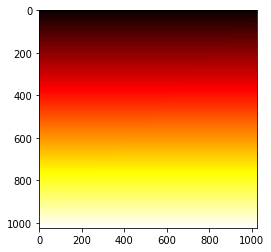

262144
1.5869836807250977
1


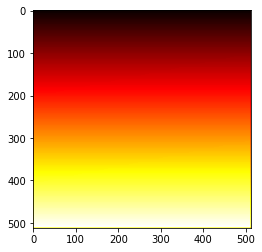

65536
0.4102177619934082
1


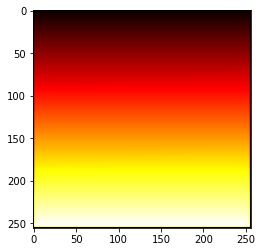

16384
0.10611248016357422
1


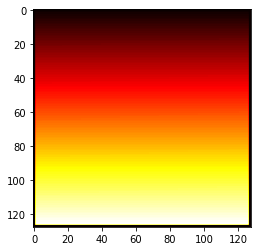

4096
0.025298595428466797
1


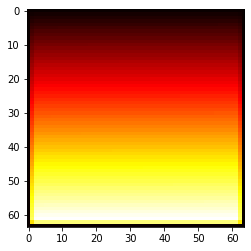

1024
0.005630970001220703
1


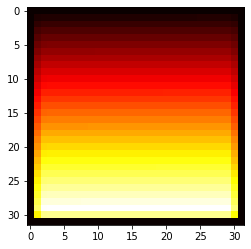

256
0.0012035369873046875
1


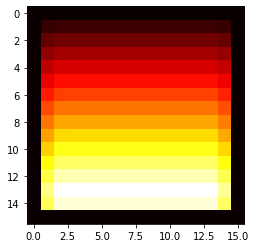

6
20
64
                     Start prolognation to intermediate phase
0.002335071563720703
64
10


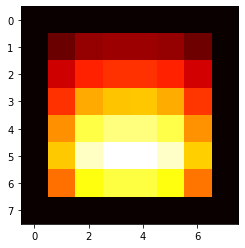

                   Start restriction from intermediate phase to minimum COARSE phase
64
0.003329038619995117
10


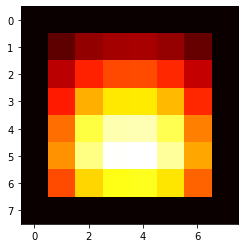

                   Start prolongation from minimum COARSE phase to FINE grid
0.013838529586791992
64
58


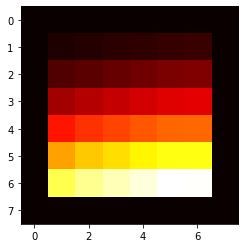

256
0.12630224227905273
256
98


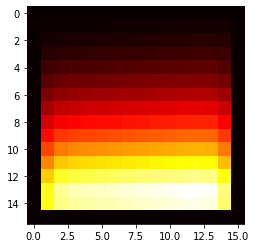

1024
0.5839323997497559
1024
100


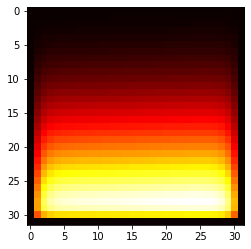

4096
2.4232356548309326
4096
100


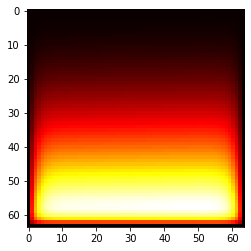

16384
10.031989336013794
16384
100


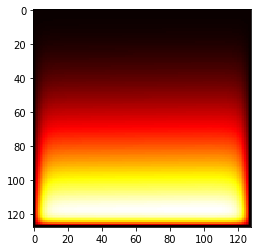

65536
40.4968798160553
65536
100


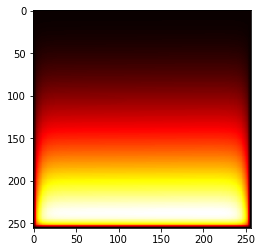

262144
163.0808765888214
262144
100


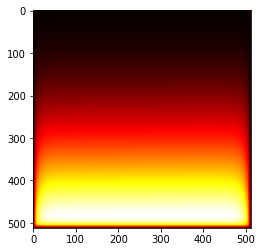

1048576
6.764776706695557
Final Residual
67.84701298043889
1048576
1


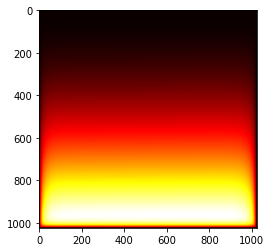

1048576
W_MultiGrid Took
239.01865005493164
Number of equivalent iterations on the FINE GRID
35.66455078125


In [126]:
x, w_residual = w_multigrid(u, min=6, intermediate=8,  omega=0.6, sig=1000, sor=1, mode_restrict=1)

20
         Start restriction
1048576
6.41053032875061
1


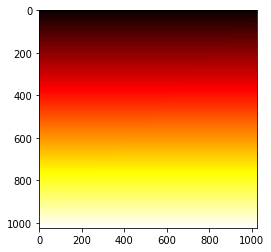

262144
1.6470377445220947
1


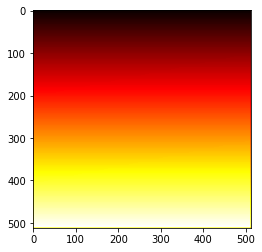

65536
0.4437553882598877
1


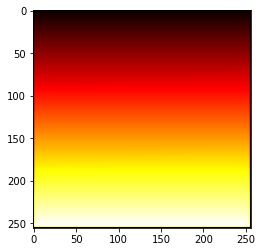

16384
0.10794210433959961
1


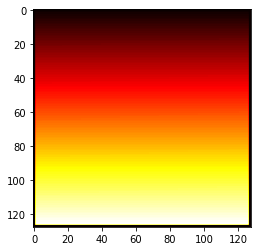

4096
0.029471158981323242
1


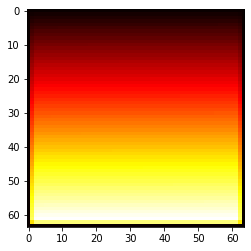

1024
0.005903005599975586
1


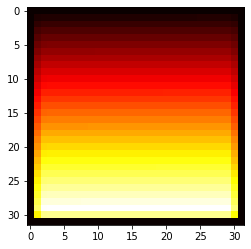

256
0.001630544662475586
1


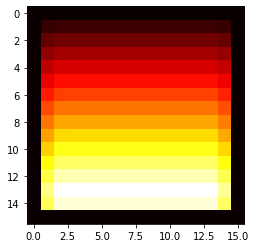

[     0.              0.              0.              0.
      0.              0.              0.              0.
      0.          73676.13830462  75003.11432955  75074.99333058
  75146.87234653  75218.75137738  75290.63042314      0.
      0.         147281.0991016  149864.38887292 149937.49389927
 150010.59894057 150083.70399684 150156.80906806      0.
      0.         220884.84381891 224723.22192934 224796.32730965
 224869.43270492 224942.53811515 225015.64354034      0.
      0.         294488.60770758 299582.07442111 299655.18015538
 299728.28590462 299801.39166881 299874.49744797      0.
      0.         368092.39076759 374440.94634822 374514.05243646
 374587.15853966 374660.26465782 374733.37079094      0.
      0.         441696.19299895 449299.83771068 449372.94415289
 449446.05061005 449519.15708218 449592.26356926      0.
      0.              0.              0.              0.
      0.              0.              0.              0.        ]
6
GOAL COUNT
20
64
         Sta

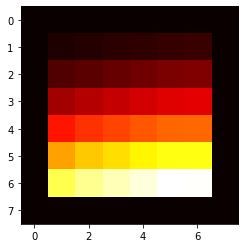

256
0.12199878692626953
256
98


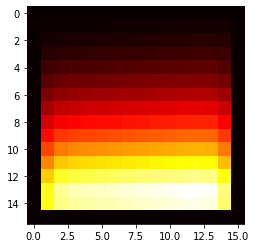

1024
0.604684591293335
1024
100


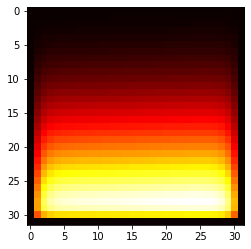

4096
2.4648947715759277
4096
100


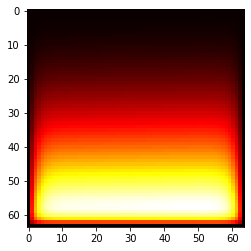

16384
10.196630239486694
16384
100


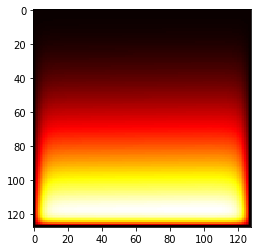

65536
40.79925560951233
65536
100


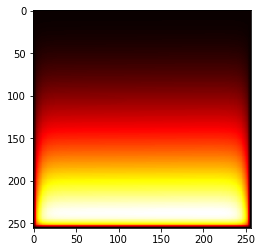

262144
166.92420482635498
262144
100


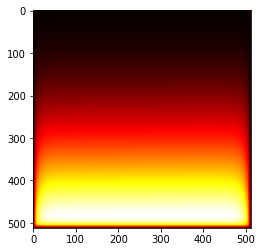

1048576
6.591980695724487
Final Residual
67.84701298043889
1048576
1


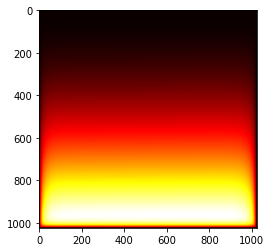

1048576
V_MultiGrid Took in SECONDS
242.9315836429596
Number of equivalent iterations on the FINE GRID
35.6627197265625


In [129]:
x, v_residual = v_multigrid(u, min=6, omega=0.6, sig=1000, sor=1, mode_restrict=1)

Let us Run SOR on the fine grid, with the same initial guess we used for both multigrid methods, during as many equivalent fine grid iterations ***'here it's 36'*** it took to complete the multigrid cycles and compare the results to see which method got the most convergence in terms of final residual.

Conventional SOR exclusively on the FINE grid took
235.9404354095459


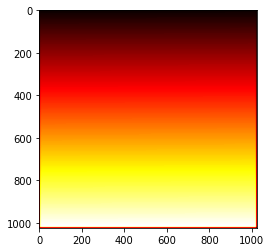

Final Residual
679358.7866246911
36


In [132]:
N=u.size    
n=int(math.sqrt(N))
h=1/(n-1)
A = sparse_fivediag(N,h, 1000)
f = function(N,h)
print('Conventional SOR exclusively on the FINE grid took')
u2,r,d,c = sparse_solver(A,f,u,0.6,1e-6,36)
plot_heatmap(u2)
print('Final Residual')
print(r[-1])
print(c)

As we can see here although both methods took almost the same time to complete, using multigrid we were able to get much closer to what the continuous solution actually looks like. On the other hand using the equivalent number of iterative solvers exclusively on the fine grid gave us no convergence towards the final solution at all.In fact, it can be deduced that the fine grid stayed almost stationary and solving on it reaped no tangible benefits, those 36 iterations did practically nothiong to our fine grid.

This can be accentuated even more when we look at the final residual for both cycles.
Multigrid has a relatively small **final residual** of ***67.847***, whereas the regular solver was dramatically far with a final residual of ***679358***
That is a whopping improvement of residual of **10013** times. Surely to attain that final residual obtained via multigrid solving exclusively on the fine grid would have taken us days or even weeks of calculations!!
This is the **fundamental profit** of using multi-grid we get to speed up our cycle's convergence by thinking hierarchacally and focusing on how to **reduce the number of calculations required** to get a decent approximation of our continuous system.

Our Initial Guess


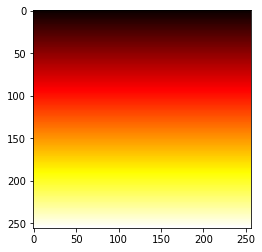

Final Residual
25.66324130858886


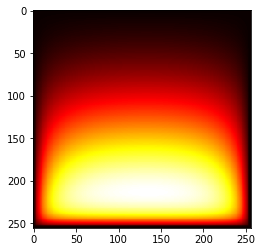

W_MultiGrid Took
14.337056159973145
Number of equivalent iterations on the FINE GRID
35.681640625


In [164]:
x, w_residual = w_multigrid(u, min=6, intermediate=8,  omega=0.6, sig=10, sor=1, mode_restrict=1)

Our Initial Guess


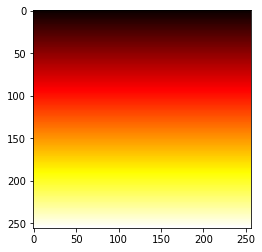

Final Residual
25.66325972297328


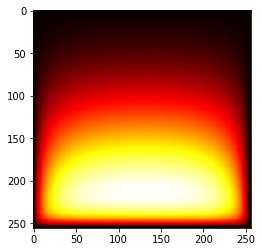

V_MultiGrid Took in SECONDS
14.432188510894775
Number of equivalent iterations on the FINE GRID
35.6328125


In [165]:
x, v_residual = v_multigrid(u, min=6,  omega=0.6, sig=10, sor=1, mode_restrict=1)

Conventional SOR exclusively on the FINE grid took


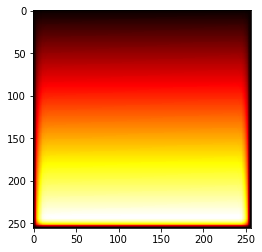

Final Residual
14984.745999666584
54


In [157]:
N=u.size    
n=int(math.sqrt(N))
h=1/(n-1)
A = sparse_fivediag(N,h, 10)
f = function(N,h)
print('Conventional SOR exclusively on the FINE grid took')
u2,r,d,c = sparse_solver(A,f,u,0.6,1e-6,54)
plot_heatmap(u2)
print('Final Residual')
print(r[-1])
print(c)

With a smaller grid ***256x256*** we still see the benefits as multigrid gave us a final residual of **14.1723** whereas finegrid operations gave us a much larger **14984.745**. Although the gain in error reduction is not as dramatic as the case with a 1024x1024 matrix we can still reap then benefits of multigrid on slightly smaller matrices.
It should be noted that V_multigrid gave us less final number of finegrid iterations than W_multigrid. This is likely due to the fact that W cycle is executuing more iterations than V overall due to the UP and DOWN nature of W.


Now let's check what results we would get with even smaller grids to verify the **scalability** of multigrid methods.

Our Initial Guess


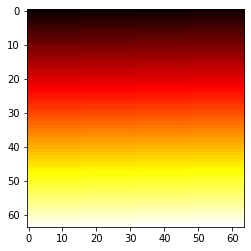

Final Residual
6.415293728932651


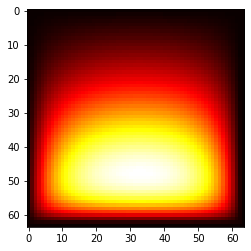

W_MultiGrid Took
1.099243402481079
Number of equivalent iterations on the FINE GRID
35.90625


In [167]:
x, w_residual = w_multigrid(u, min=6, intermediate=8,  omega=0.6, sig=10, sor=1, mode_restrict=1)

Our Initial Guess


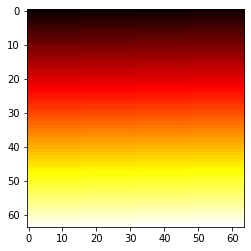

Final Residual
6.415298493284477


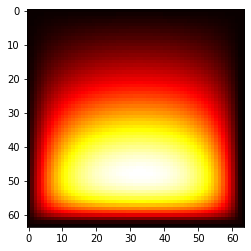

V_MultiGrid Took in SECONDS
1.104372262954712
Number of equivalent iterations on the FINE GRID
35.125


In [168]:
x, v_residual = v_multigrid(u, min=6,  omega=0.6, sig=10, sor=1, mode_restrict=1)

Conventional SOR exclusively on the FINE grid took


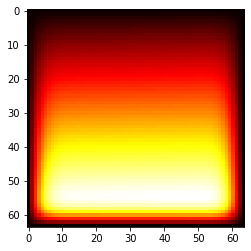

Final Residual
1104.0814617812027
36


In [177]:
N=u.size    
n=int(math.sqrt(N))
h=1/(n-1)
A = sparse_fivediag(N,h, 1000)
f = function(N,h)
print('Conventional SOR exclusively on the FINE grid took')
u2,r,d,c = sparse_solver(A,f,u,0.6,1e-6,36)
plot_heatmap(u2)
print('Final Residual')
print(r[-1])
print(c)

Although the benefits are getting less and less dramatic as we resort to smaller and smaller grids, we can see a remarkable gain in error reduction with respect to ***64x64*** finegrid iterations. 


Final Residuals are **6.4152** for multigtid VS **1104** for finegrid solvers. 
We have a **171x** gain in error reduction as opposed to *10013x* on a much larger grid(1024x1024).


Nevertheless the profits in computational cost are stil evident.
In our last trial we will proceed to a 32x32 matrix and check whether it's worthwhile.

Our Initial Guess


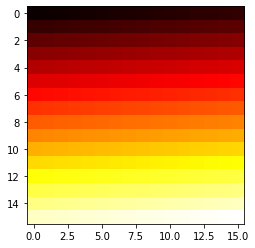

Final Residual
1.457029176293528


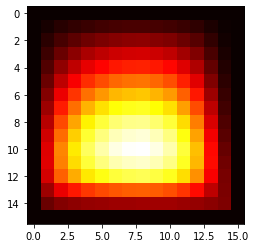

W_MultiGrid Took
0.3588273525238037
Number of equivalent iterations on the FINE GRID
30.25


In [171]:
x, w_residual = w_multigrid(u, min=6, intermediate=8,  omega=0.6, sig=10, sor=1, mode_restrict=1)

Our Initial Guess


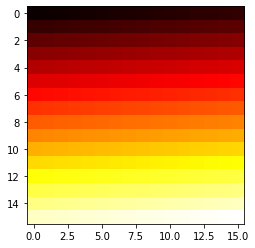

Final Residual
1.456924265848501


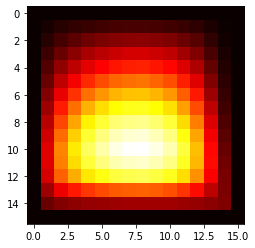

V_MultiGrid Took in SECONDS
0.4991028308868408
Number of equivalent iterations on the FINE GRID
27.0


In [172]:
x, v_residual = v_multigrid(u, min=6,  omega=0.6, sig=10, sor=1, mode_restrict=1)

Conventional SOR exclusively on the FINE grid took


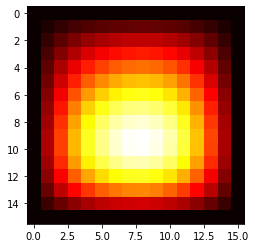

Final Reisdual
20.546935078319773
31


In [180]:
N=u.size    
n=int(math.sqrt(N))
h=1/(n-1)
A = sparse_fivediag(N,h, 10)
f = function(N,h)
print('Conventional SOR exclusively on the FINE grid took')
u2,r,d,c = sparse_solver(A,f,u,0.6,1e-6,31)
plot_heatmap(u2)
print('Final Reisdual')
print(r[-1])
print(c)

As we get to the smallest grid of our trials we can notice that we are still consistently getting an inferior error for multigrid vs fine_grid solvers.Final Residuals are ***1.456*** vs ***20.546*** which is not as impressive as previous trials but proves a point that multigrid can even speed up the resolution of coarse grids hence it is ***scalable*** even to smaller grids and it is worthwhile on all grid sizes.


Similarly to what we noticed before the W pattern is taking more equivalent finegrid iterations than the V pattern.



Now Let's Study the impact restriction methods have on convergence and whether they'll make a big difference in reducing our final error.

Our Initial Guess


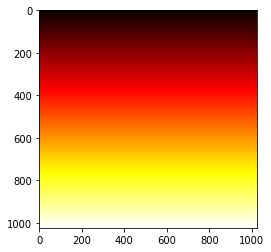

Final Residual
95.59251781509823


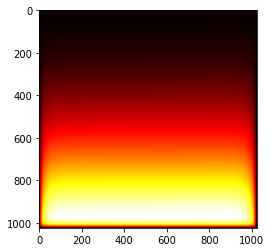

W_MultiGrid Took
231.4367687702179
Number of equivalent iterations on the FINE GRID
35.66082763671875


In [182]:
x, w_injection_residual = w_multigrid(u, min=6, intermediate=8,  omega=0.6, sig=1000, sor=1, mode_restrict=0)

Our Initial Guess


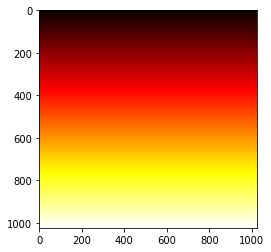

Final Residual
95.59251781509823


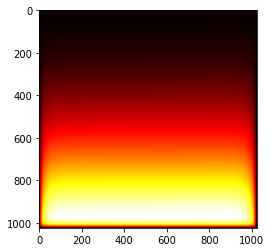

W_MultiGrid Took
235.41562056541443
Number of equivalent iterations on the FINE GRID
35.66082763671875


In [183]:
x, w_half_residual = w_multigrid(u, min=6, intermediate=8,  omega=0.6, sig=1000, sor=1, mode_restrict=1)

Our Initial Guess


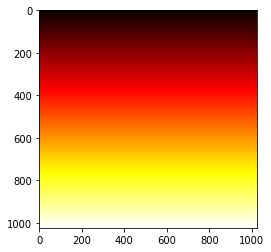

Final Residual
95.59251781509823


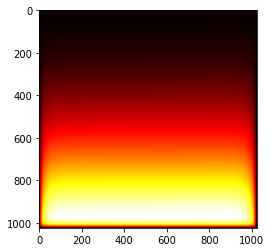

W_MultiGrid Took
236.97327280044556
Number of equivalent iterations on the FINE GRID
35.66082763671875


In [184]:
x, full_residual = w_multigrid(u, min=6, intermediate=8,  omega=0.6, sig=1000, sor=1, mode_restrict=2)

We can conclude that injection leads to faster execution time (231 seconds) than half(235.5) and full(237), which is due to the less amount of computations resulting from simply restricting by placement without any deivisons or multiplications.
Although we see that all three restrictions methods leas to the same FINAL RESIDUAL in this particular circumstance, let's try for other circumstances.

Our Initial Guess


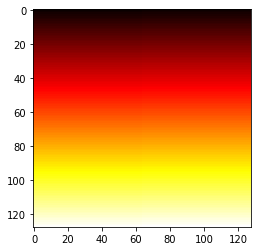

Final Residual
9.688875764981391


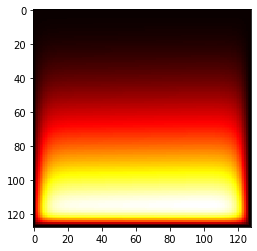

W_MultiGrid Took
2.724168062210083
Number of equivalent iterations on the FINE GRID
30.2421875


In [195]:
x, w_injection_residual = w_multigrid(u, min=6, intermediate=8,  omega=0.6, sig=1000, sor=1, mode_restrict=0)

Our Initial Guess


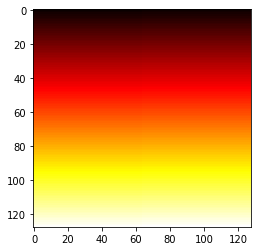

Final Residual
9.688875764981391


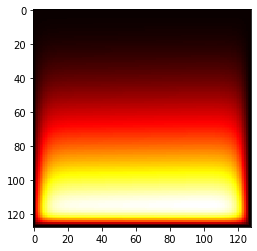

W_MultiGrid Took
2.749943256378174
Number of equivalent iterations on the FINE GRID
30.2421875


In [196]:
x, w_half_residual = w_multigrid(u, min=6, intermediate=8,  omega=0.6, sig=1000, sor=1, mode_restrict=1)

Our Initial Guess


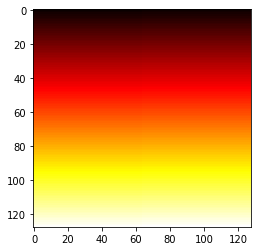

Final Residual
9.688875764981391


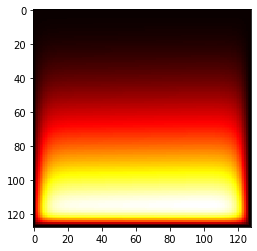

W_MultiGrid Took
2.7722246646881104
Number of equivalent iterations on the FINE GRID
30.2421875


In [194]:
x, w_full_residual = w_multigrid(u, min=6, intermediate=8,  omega=0.6, sig=1000, sor=1, mode_restrict=2)

Our Initial Guess


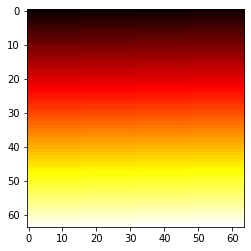

Final Residual
6.662577441552602


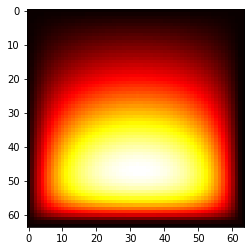

W_MultiGrid Took
0.9669115543365479
Number of equivalent iterations on the FINE GRID
35.90625


In [209]:
x, w_full_residual = w_multigrid(u, min=6, intermediate=8,  omega=0.6, sig=0.5, sor=1, mode_restrict=2)

Our Initial Guess


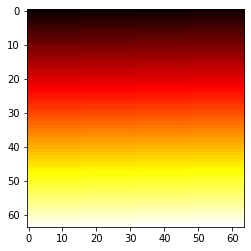

Final Residual
6.662577711085055


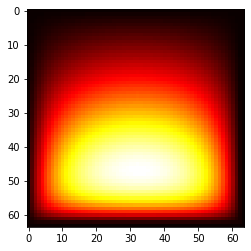

W_MultiGrid Took
0.9396700859069824
Number of equivalent iterations on the FINE GRID
35.90625


In [210]:
x, w_full_residual = w_multigrid(u, min=6, intermediate=8,  omega=0.6, sig=0.5, sor=1, mode_restrict=1)

Our Initial Guess


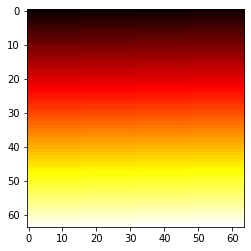

Final Residual
6.662577951868688


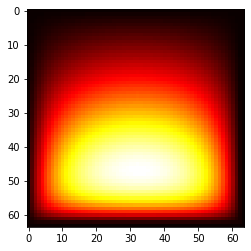

W_MultiGrid Took
0.9659252166748047
Number of equivalent iterations on the FINE GRID
35.90625


In [211]:
x, w_full_residual = w_multigrid(u, min=6, intermediate=8,  omega=0.6, sig=0.5, sor=1, mode_restrict=0)